## Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

random_seed = 2024

## I. Data-Cleaning

### 1. diet.csv

In [16]:
users_diet_data = pd.read_csv('../aufgabe/training_dataset/diet.csv')
# print(users_diet.head())
# users_diet.shape
# users_diet.dtypes

# Nullwerte
# users_diet.isnull().sum()

# 1. Spalte "Diet"
# -> ein Nullwert drin 
#users_diet[users_diet["Diet"].isna()]

# Author 646062A ohne Wert für Diet -> Weg mit dem Hund
users_diet_data = users_diet.drop(users_diet[users_diet["Diet"].isna()].index).reset_index(drop=True)

# Weitere missing values finden: z.B. <empty field>, "0", ".", "999", "NA" ...
# users_diet[(users_diet["Diet"] == "") | (users_diet["Diet"] == ".") | (users_diet["Diet"] == "999")]


# 2. Spalte "Age"
# users_diet[users_diet["Age"] > 100]
# users_diet[users_diet["Age"] < 5]
# print("Range Alter", users_diet["Age"].min(), users_diet["Age"].max())

# 3. Spalte "AuthorId"
# print("Einzigartige IDs: ", users_diet["AuthorId"].nunique(), users_diet.shape[0])


# Datentyp bei "Diet" zu Category ändern
users_diet_data["Diet"] = users_diet_data['Diet'].astype("category")
users_diet_data.dtypes


AuthorId      object
Diet        category
Age            int64
dtype: object

### 2. reviews.csv

In [17]:
reviews_data = pd.read_csv("../aufgabe/training_dataset/reviews.csv")

# Test-Daten -> TestSetId != NaN, die anderen nicht für Modelle verwenden
reviews_data = reviews_data[reviews_data["TestSetId"].isna()].reset_index(drop=True)
reviews_data.loc[reviews_data['Rating'].isna(), "Rating"] = 999
reviews_data["Rating"] = reviews_data["Rating"].astype("category")

# Like column zu boolean
reviews_data["Like"] = reviews_data["Like"].astype("bool")

# reviews_data_test.dtypes


/var/folders/j0/z37d__mj75g9k_jcd30hbw0c0000gn/T/ipykernel_45417/1333568789.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_data = pd.read_csv("../aufgabe/training_dataset/reviews.csv")


### 3. requests.csv

In [18]:
requests_data = pd.read_csv("../aufgabe/training_dataset/requests.csv")
requests_data.head()

# Column: Time
# Runden
""" 
Column Time -> runden, da Nachkommastellen bei Kochzeit irrelevant
Beschreibung: The duration a recipe should take at most (including the time reserved
for the preparation and cooking).
"""
requests_data["Time"] = requests_data["Time"].round(1)

# Teilweise negative Werte -> 0
requests_data.loc[requests_data["Time"] <= 0, "Time"] = 0
"""
Test, ob negative Werte immer False als "Like" haben -> stimmt aber nicht siehe Code:
Requests mit [AuthorId, RecipeId] time <= 0 mit reviews [AuthorId, RecipeId] joinen und dort like checken
joined_data = requests_data.merge(reviews_data_test, on=["AuthorId", "RecipeId"], how="left")
joined_data = joined_data[joined_data["Time"] <= 0]
joined_data = joined_data[~joined_data["Like"].isna()]
"""

# Column: HighCalories
requests_data["HighCalories"] = requests_data["HighCalories"].astype("bool")

# Column: HighProtein
"""
2 Werte: Indifferent und Yes
Daraus wird boolean indifferent = False und Yes = True
"""
requests_data.loc[requests_data["HighProtein"] == "Indifferent", "HighProtein"] = 0
requests_data.loc[requests_data["HighProtein"] == "Yes", "HighProtein"] = 1
requests_data["HighProtein"] = requests_data["HighProtein"].astype("bool")

# Column: LowFat
requests_data["LowFat"] = requests_data["LowFat"].astype("bool")

# Column: LowSugar
"""
2 Werte: Indifferent und 0. Interpretation: 0 -> user braucht kein low-sugar Inhalt, Indifferent -> User ist es egal
Daraus wird boolean 0 = False und indifferent = True
"""
requests_data.loc[requests_data["LowSugar"] == "0", "LowSugar"] = 0
requests_data.loc[requests_data["LowSugar"] == "Indifferent", "LowSugar"] = 1
requests_data["LowSugar"] = requests_data["LowSugar"].astype("bool")

# Column HighFiber
requests_data["HighFiber"] = requests_data["HighFiber"].astype("bool")

# requests_data["HighFiber"].unique()
# requests_data.head(20)


### 4. recipes.csv

In [33]:
recipes_data = pd.read_csv("../aufgabe/training_dataset/recipes.csv")
threshold = 3.5

# Column CookTime und Column PrepTime
"""
Outlier Detection:
Außerhalb von 3,5*Standardabweichung -> Outlier

=> Outlier werden entfernt
"""
# Name to lower
recipes_data["Name"] = recipes_data["Name"].str.lower()

# log transformation
recipes_data["CookTime"] = recipes_data["CookTime"].apply(lambda x: np.log(x) if x > 0 else x)
recipes_data["PrepTime"] = recipes_data["PrepTime"].apply(lambda x: np.log(x) if x > 0 else x)
# print(recipes_data["PrepTime"].describe())

# plt.hist(recipes_data['PrepTime'], bins=10)
# plt.title('Histogram of Cook Time')
# plt.xlabel('Cook Time')
# plt.ylabel('Frequency')
# plt.show()

std_CookTime = recipes_data['CookTime'].std()
mean_CookTime = recipes_data['CookTime'].mean()
upper_limit_CookTime = mean_CookTime + threshold * std_CookTime
lower_limit_CookTime = mean_CookTime - threshold * std_CookTime


std_PrepTime = recipes_data['PrepTime'].std()
mean_PrepTime = recipes_data['PrepTime'].mean()
upper_limit_PrepTime = mean_PrepTime + threshold * std_PrepTime
lower_limit_PrepTime = mean_PrepTime - threshold * std_PrepTime

recipes_data = recipes_data[(recipes_data["CookTime"] >= lower_limit_CookTime) & (recipes_data['CookTime'] <= upper_limit_CookTime)]
recipes_data = recipes_data[(recipes_data["PrepTime"] >= lower_limit_PrepTime) & (recipes_data['PrepTime'] <= upper_limit_PrepTime)]
print("Shape vorher: ", recipes_data.shape)


# Column RecipeCategory
recipes_data["RecipeCategory"] = recipes_data["RecipeCategory"].astype("category")


# Column RecipeIngredientQuantities und Column RecipeIngredientParts
# zu liste von strings umwandeln
recipes_data["RecipeIngredientQuantities"] = recipes_data["RecipeIngredientQuantities"].str.replace('character(0)', '').str.lstrip('"c("').str.replace('"', '').str.replace(")", "").str.replace('\\', '').str.split(",")
recipes_data["RecipeIngredientParts"] = recipes_data["RecipeIngredientParts"].str.lower().replace('character(0)', '').str.lstrip('"c("').str.replace('"', '').str.replace(")", "").str.replace('\\', '').str.split(",")

# Einteilung ob die Zutat in der Liste ist oder nicht
# Fleisch
value_meat = ["chicken", "veal", "pork", "beef", "turkey", "ham", "bacon", "lamb", "duck", "goose", "rabbit", "venison", "quail", "pheasant", "alligator", "sausage"]
# Meeresfrüchte
value_sea = ["fish", "crab", "lobster", "shrimp", "prawn", "clam", "mussel", "scallop", "squid", "octopus", "anchovy", "sardine", "tuna", "salmon", "trout", "herring", "cod", "mackerel", "bass", "swordfish", "sturgeon", "walleye", "caviar", "crayfish", "cuttlefish", "sea cucumber", "sea snail", "sea bass", "sea bream", "sea trout", "seafood", "shellfish"]
# vegetarisch
value_vegetarian = ["tofu", "seitan", "tempeh", "plant-based"]
# vegan
value_vegan = ["vegan"]

def beinhaltet_substring(ingredient_list, category_list):
    for ingredient in ingredient_list:
        if any(cat in ingredient for cat in category_list):
            return 1
    return 0

recipes_data["Meat"] = recipes_data["RecipeIngredientParts"].apply(lambda x: beinhaltet_substring(x, value_meat))
recipes_data["Seafood"] = recipes_data["RecipeIngredientParts"].apply(lambda x: beinhaltet_substring(x, value_sea))
recipes_data["Vegetarian"] = recipes_data["RecipeIngredientParts"].apply(lambda x: beinhaltet_substring(x, value_vegetarian))
recipes_data["Vegan"] = recipes_data["RecipeIngredientParts"].apply(lambda x: beinhaltet_substring(x, value_vegan))


# weitere Unterteilung, falls mehrere Kategorien anschlagen und falls alles 0, dann vegetarisch 1
for index, row in recipes_data.iterrows():
    if(beinhaltet_substring([row["Name"]], value_vegan) == 1): 
        recipes_data.loc[index, ["Vegan"]] = 1
        recipes_data.loc[index, ["Vegetarian"]] = 0
        recipes_data.loc[index, ["Seafood"]] = 0
        recipes_data.loc[index, ["Meat"]] = 0
    elif(row["Meat"] == 1 or row["Seafood"] == 1):
        recipes_data.loc[index, ["Vegetarian"]] = 0
        recipes_data.loc[index, ["Vegan"]] = 0
    elif(row["Vegetarian"] == 0 and row["Vegan"] == 0):
        recipes_data.loc[index, ["Vegetarian"]] = 1


# print(recipes_data[["RecipeId", "Meat", "Seafood", "Vegetarian", "Vegan"]].head(20))
# print(recipes_data[(recipes_data["Vegan"] == 0) & (recipes_data["Vegetarian"] == 0) & (recipes_data["Meat"] == 0) & (recipes_data["Seafood"] == 0)].value_counts())


# Column Calories
# Outlier weg
recipes_data["Calories"] = recipes_data["Calories"].apply(lambda x: np.log(x) if x > 0 else x)

std_Calories = recipes_data['Calories'].std()
mean_Calories = recipes_data['Calories'].mean()
upper_limit_Calories = mean_Calories + threshold * std_Calories
lower_limit_Calories = mean_Calories - threshold * std_Calories

recipes_data = recipes_data[(recipes_data["Calories"] >= lower_limit_Calories) & (recipes_data['Calories'] <= upper_limit_Calories)]


# Column FatContent
# Oulier weg

recipes_data["FatContent"] = recipes_data["FatContent"].apply(lambda x: np.log(x+1) if x > 0 else x)

std_FatContent = recipes_data['FatContent'].std()
mean_FatContent = recipes_data['FatContent'].mean()
upper_limit_FatContent = mean_FatContent + threshold * std_FatContent
lower_limit_FatContent = mean_FatContent - threshold * std_FatContent

recipes_data = recipes_data[(recipes_data["FatContent"] >= lower_limit_FatContent) & (recipes_data['FatContent'] <= upper_limit_FatContent)]


# Column SaturatedFatContent
# Outlier weg
recipes_data["SaturatedFatContent"] = recipes_data["SaturatedFatContent"].apply(lambda x: np.log(x+1) if x > 0 else x)

std_SaturatedFatContent = recipes_data['SaturatedFatContent'].std()
mean_SaturatedFatContent = recipes_data['SaturatedFatContent'].mean()
upper_limit_SaturatedFatContent = mean_SaturatedFatContent + threshold * std_SaturatedFatContent
lower_limit_SaturatedFatContent = mean_SaturatedFatContent - threshold * std_SaturatedFatContent

recipes_data = recipes_data[(recipes_data["SaturatedFatContent"] >= lower_limit_SaturatedFatContent) & (recipes_data['SaturatedFatContent'] <= upper_limit_SaturatedFatContent)]


# Column CholesterolContent
# Outlier weg
recipes_data["CholesterolContent"] = recipes_data["CholesterolContent"].apply(lambda x: np.log(x + 1) if x > 0 else x)

std_CholesterolContent = recipes_data['CholesterolContent'].std()
mean_CholesterolContent = recipes_data['CholesterolContent'].mean()
upper_limit_CholesterolContent = mean_CholesterolContent + threshold * std_CholesterolContent
lower_limit_CholesterolContent = mean_CholesterolContent - threshold * std_CholesterolContent

recipes_data = recipes_data[(recipes_data["CholesterolContent"] >= lower_limit_CholesterolContent) & (recipes_data['CholesterolContent'] <= upper_limit_CholesterolContent)]


# Column SodiumContent
# Outlier weg
recipes_data["SodiumContent"] = recipes_data["SodiumContent"].apply(lambda x: np.log(x + 1) if x > 0 else x)

std_SodiumContent = recipes_data['SodiumContent'].std()
mean_SodiumContent = recipes_data['SodiumContent'].mean()
upper_limit_SodiumContent = mean_SodiumContent + threshold * std_SodiumContent
lower_limit_SodiumContent = mean_SodiumContent - threshold * std_SodiumContent

recipes_data = recipes_data[(recipes_data["SodiumContent"] >= lower_limit_SodiumContent) & (recipes_data['SodiumContent'] <= upper_limit_SodiumContent)]


# Column CarbohydrateContent
# Outlier weg
recipes_data["CarbohydrateContent"] = recipes_data["CarbohydrateContent"].apply(lambda x: np.log(x+1) if x > 0 else x)

std_CarbohydrateContent = recipes_data['CarbohydrateContent'].std()
mean_CarbohydrateContent = recipes_data['CarbohydrateContent'].mean()
upper_limit_CarbohydrateContent = mean_CarbohydrateContent + threshold * std_CarbohydrateContent
lower_limit_CarbohydrateContent = mean_CarbohydrateContent - threshold * std_CarbohydrateContent

recipes_data = recipes_data[(recipes_data["CarbohydrateContent"] >= lower_limit_CarbohydrateContent) & (recipes_data['CarbohydrateContent'] <= upper_limit_CarbohydrateContent)]


# Column FiberContent
# Outlier weg
recipes_data["FiberContent"] = recipes_data["FiberContent"].apply(lambda x: np.log(x+1) if x > 0 else x)

std_FiberContent = recipes_data['FiberContent'].std()
mean_FiberContent = recipes_data['FiberContent'].mean()
upper_limit_FiberContent = mean_FiberContent + threshold * std_FiberContent
lower_limit_FiberContent = mean_FiberContent - threshold * std_FiberContent

recipes_data = recipes_data[(recipes_data["FiberContent"] >= lower_limit_FiberContent) & (recipes_data['FiberContent'] <= upper_limit_FiberContent)]


# Column SugarContent
# Outlier weg
recipes_data["SugarContent"] = recipes_data['SugarContent'].apply(lambda x: np.log(x+1) if x > 0 else x)

std_SugarContent = recipes_data['SugarContent'].std()
mean_SugarContent = recipes_data['SugarContent'].mean()
upper_limit_SugarContent = mean_SugarContent + threshold * std_SugarContent
lower_limit_SugarContent = mean_SugarContent - threshold * std_SugarContent

recipes_data = recipes_data[(recipes_data["SugarContent"] >= lower_limit_SugarContent) & (recipes_data['SugarContent'] <= upper_limit_SugarContent)]



# Column ProteinContent
# Outlier weg
recipes_data["ProteinContent"] = recipes_data["ProteinContent"].apply(lambda x: np.log(x+1) if x > 0 else x)

std_ProteinContent = recipes_data['ProteinContent'].std()
mean_ProteinContent = recipes_data['ProteinContent'].mean()
upper_limit_ProteinContent = mean_ProteinContent + threshold * std_ProteinContent
lower_limit_ProteinContent = mean_ProteinContent - threshold * std_ProteinContent

recipes_data = recipes_data[(recipes_data["ProteinContent"] >= lower_limit_ProteinContent) & (recipes_data['ProteinContent'] <= upper_limit_ProteinContent)]


# Column RecipeServings & Column RecipeYield
"""
RecipeServings: Anzahl der Portionen, die das Rezept ergibt
RecipeYield: Gibt an, wie viele Stücke man aus dem Rezept erhält. Ein Rezept ergibt zum Beispiel 1/2 Liter Suppe, was 2 Portionen entspricht.
-> Versuch: RecipeYield zu standardisieren z.B. in Liter, Gramm, Stück, ... -> Problem: >2000 verschiedene Einheiten (zu viele) -> RecipeYield nicht verwenden
-> Stattdessen auf RecipeServings zurückgreifen und fehlende Werte durch randomforest imputieren

Wichtig: Da RecipeServings schlecht verteilt ist (z.b. meisten Werte zwischen 0 und 10, aber auch Werte >1000) werden die Modelle ungenau
-> Lösung: Verwendung von Klassen: Einteilung in Serving-Size: small, medium, large, ...
-> Wichtig: One-hot-encoding nutzen (da es sich um Kategorien handelt) -> 3 Spalten: small, medium, large

"""

# Correlation Matrix von numerischen Werten
# corr = recipes_data[["CookTime", "PrepTime", "Calories", "FatContent", "CarbohydrateContent", "FiberContent", "SugarContent", "ProteinContent", "RecipeServings"]].corr(numeric_only=True)
# print(corr)

# RecipeYield
# recipes_data["RecipeYield_Quantity"] = recipes_data["RecipeYield"].str.split(" ").str[0]
# recipes_data["RecipeYield_Unit"] = recipes_data["RecipeYield"].str.split(" ").str[1]
recipes_data.drop(columns=["RecipeYield"], inplace=True)


# RecipeServings
# Logarithmieren von RecipeServings, um die Verteilung zu verbessern
recipes_data["RecipeServings"] = recipes_data["RecipeServings"].apply(lambda x: np.log(x) if x > 0 else x)

# plt.figure(figsize=(10, 6))
# plt.hist(recipes_data['RecipeServings'], bins=10)
# plt.title('Histogram of Recipe Servings')
# plt.xlabel('Recipe Servings')
# plt.ylabel('Frequency')
# plt.show()

# Outlier weg
std_RecipeServings = recipes_data[recipes_data['RecipeServings'].notna()]["RecipeServings"].std()
mean_RecipeServings = recipes_data[recipes_data['RecipeServings'].notna()]["RecipeServings"].mean()
# print(recipes_data['RecipeServings'].describe())
"""
mean         1.770398
std          0.781950
min          0.000000
25%          1.386294 -> 25% der Werte sind 1.386294 oder kleiner -> small
50%          1.791759 -> 50% der Werte sind 1.791759 oder kleiner -> medium
75%          2.079442 -> 75% der Werte sind 2.079442 oder kleiner -> large
max          6.907755
"""

upper_limit_RecipeServings = mean_RecipeServings + threshold * std_RecipeServings
lower_limit_RecipeServings = mean_RecipeServings - threshold * std_RecipeServings

recipes_data = recipes_data[((recipes_data["RecipeServings"] >= lower_limit_RecipeServings) & (recipes_data['RecipeServings'] <= upper_limit_RecipeServings)) | (recipes_data['RecipeServings'].isna())]
print("Shape nach Kürzung der Outlier: ", recipes_data.shape)

recipes_data_description = recipes_data.describe()

# Conditions
conditions = [
    (recipes_data["RecipeServings"] <= recipes_data_description.loc["25%", "RecipeServings"]),
    (recipes_data["RecipeServings"] > recipes_data_description.loc["25%", "RecipeServings"]) & (recipes_data["RecipeServings"] <= recipes_data_description.loc["75%", "RecipeServings"]),
    (recipes_data["RecipeServings"] > recipes_data_description.loc["75%", "RecipeServings"])
]
# choices: small - 0, medium - 1, large - 2
choices = [0, 1, 2]

# Discretization von RecipeServings -> Klassen: small = 0, medium = 1, large = 2 -> one-hot-encoding
recipes_data["ServingClass"] = np.select(conditions, choices, default=np.nan)
# Werte mit NA werden durch median 1 ersetzt.
recipes_data.loc[recipes_data['RecipeServings'].isna(), "ServingClass"] = 1

# In Csv
# path_recipesData_marco = "../cvs/Marco/recipes_data.csv"
# recipes_data.to_csv(path_recipesData_marco, index=False)



# Versuch: Fehlende Daten zu imputieren, nicht geklappt!
"""
# fehlende Werte in RecipeServings durch random forest imputieren
features = ['CookTime', 'PrepTime', 'Calories', 'FatContent', 'FiberContent', 'ProteinContent']

# test_data with and without RecipeServings, training_data only with RecipeServings
known_servings = recipes_data[recipes_data['ServingClass'].notna()]
unknown_servings = recipes_data[recipes_data['ServingClass'].isna()]

X = known_servings[features]
y_known = known_servings["ServingClass"]

# print(X)
# print(y_known)
X_train, X_val, y_train, y_val = train_test_split(X, y_known, test_size=0.3, random_state=random_seed)
# print('Training Features Shape:', X_train.shape)
# print('Training Labels Shape:', y_train.shape)
# print('Validation Features Shape:', X_val.shape)
# print('Validation Labels Shape:', y_val.shape)


# Model trainieren
model = RandomForestClassifier(n_estimators=200, random_state=random_seed)
model.fit(X_train, y_train)

# Model evaluieren
y_pred = model.predict(X_val)

# Bewertung des Modells
mse = mean_squared_error(y_val, y_pred)
# calculate r squared
r_squared = model.score(X_val, y_val)
print('R Squared: ', r_squared)
print('MSE Mean Squred Error: ', mse) 


# y_val together with y_pred 
y_val_pred = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
# Extract RecipeId for the validation set
recipe_ids_val = recipes_data.loc[y_val.index, 'RecipeId']
# Add RecipeId to the y_val_pred dataframe
y_val_pred['RecipeId'] = recipe_ids_val

# Display the dataframe
print(y_val_pred.head(20))


# Model anwenden um fehlende Daten zu analysieren
# X_unknown = unknown_servings[features]
# y_unknown = unknown_servings["RecipeServings"]
# y_unknown_pred = model.predict(X_unknown)


"""





Shape vorher:  (73253, 18)
Shape nach Kürzung der Outlier:  (72073, 21)


'\n# fehlende Werte in RecipeServings durch random forest imputieren\nfeatures = [\'CookTime\', \'PrepTime\', \'Calories\', \'FatContent\', \'FiberContent\', \'ProteinContent\']\n\n# test_data with and without RecipeServings, training_data only with RecipeServings\nknown_servings = recipes_data[recipes_data[\'ServingClass\'].notna()]\nunknown_servings = recipes_data[recipes_data[\'ServingClass\'].isna()]\n\nX = known_servings[features]\ny_known = known_servings["ServingClass"]\n\n# print(X)\n# print(y_known)\nX_train, X_val, y_train, y_val = train_test_split(X, y_known, test_size=0.3, random_state=random_seed)\n# print(\'Training Features Shape:\', X_train.shape)\n# print(\'Training Labels Shape:\', y_train.shape)\n# print(\'Validation Features Shape:\', X_val.shape)\n# print(\'Validation Labels Shape:\', y_val.shape)\n\n\n# Model trainieren\nmodel = RandomForestClassifier(n_estimators=200, random_state=random_seed)\nmodel.fit(X_train, y_train)\n\n# Model evaluieren\ny_pred = model.pre

## II. Feature Engineering


## III. Data Integration

Shape davor (97381, 34)
Shape danach (93057, 34)
final_table.csv
count    93057.000000
mean         0.868736
std          0.646531
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: ServingClass, dtype: float64


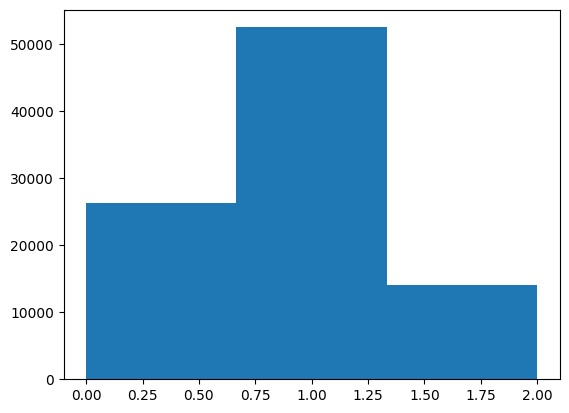

In [36]:
# Verbinden von reviews_df mit diet_df über AuthorId
combined_df1 = pd.merge(reviews_data, users_diet_data, on='AuthorId', how='left')

# Verbinden von combined_df1 mit requests_df über AuthorId und RecipeId
combined_df2 = pd.merge(combined_df1, requests_data, on=['AuthorId', 'RecipeId'], how='left')

# Verbinden von combined_df2 mit recipes_df über RecipeId
final_combined_df = pd.merge(combined_df2, recipes_data, on='RecipeId', how='left')


# Clean data without nan values - z.B. falls Rezept gelöscht wurde usw.
print("Shape davor", final_combined_df.shape)
final_combined_df = final_combined_df[final_combined_df["Time"].notna()]
final_combined_df = final_combined_df[final_combined_df["Name"].notna()]
print("Shape danach", final_combined_df.shape)


csv_file_path = 'final_table.csv'

# Save the DataFrame to CSV
final_combined_df.to_csv(csv_file_path, index=False)

# Returning the file path for download
print(csv_file_path)

# print(final_combined_df["ServingClass"].describe())
# plt.hist(final_combined_df["ServingClass"], bins=3)
# plt.show()



## III. Model Building

In [34]:
# 1. Decision Tree
from sklearn.tree import DecisionTreeClassifier

features = ['Age', 'Time', 'Diet', 'CookTime', 'PrepTime','HighCalories','HighProtein','LowFat','LowSugar','HighFiber', 'Calories', 'FatContent', 'FiberContent', 'ProteinContent', 'Meat', 'Seafood', 'Vegetarian', 'Vegan', 'HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber', 'Time', 'ServingClass']

# Diet in numerischen Wert umwandeln -> 1 = Vegetarian, 2 = Vegan, 3 = Omnivore
final_combined_df["Diet"] = final_combined_df["Diet"].apply(lambda x: 1 if x == "Vegetarian" else (2 if x == "Vegan" else 3))

print("Werte: ", final_combined_df["Like"].value_counts())

bool_columns = ['HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber', 'Meat', 'Seafood', 'Vegetarian', 'Vegan']
for col in bool_columns:
    final_combined_df[col] = final_combined_df[col].astype(int)


X = final_combined_df[features]
y = final_combined_df['Like']

# column names of final_combined_df
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_seed)
tree = DecisionTreeClassifier(random_state=random_seed)
tree.fit(X_train, y_train)

# Model evaluieren
y_pred = tree.predict(X_val)

# Bewertung des Modells
rsquared = tree.score(X_val, y_val)

print('R Squared: ', rsquared)

# Nebeneinander setzen von y_val und y_pred
y_val_pred = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})   

summeTrue = 0
summeFalse = 0
for i in range(y_pred.shape[0]):
    if y_pred[i] == True:
        summeTrue += 1
    else:
        summeFalse += 1

print("Anzahl true: ", summeTrue)
print("Anzahl false: ", summeFalse)
    

# Menge an true und false in y_pred


# final_combined_df.dtypes



Werte:  Like
False    76745
True     11635
Name: count, dtype: int64
R Squared:  0.8688617334238515
Anzahl true:  0
Anzahl false:  8838
